In [3]:
import glob
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [102]:
sorted(glob.glob('data/raw/*_*_0[1-4]*'))

['data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅',
 'data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅',
 'data/raw/01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅',
 'data/raw/01_01_04_4F実験室_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅',
 'data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出',
 'data/raw/01_02_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ外出',
 'data/raw/01_02_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ外出',
 'data/raw/01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅',
 'data/raw/01_03_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅',
 'data/raw/01_03_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅',
 'data/raw/01_11_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅',
 'data/raw/01_11_02_エネマネハウス_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅',
 'data/raw/01_11_03_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅',
 'data/raw/01_11_04_エネマネハウス_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅',
 'data/raw/01_12_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出',
 'data/raw/01_12_02_エネマネハウス_XperiaZ3_ズボン_裏上_異常_まっすぐ外出',
 'data/raw/01_12_03_エネマネハウス_XperiaZ3_カバン_裏上_異常_まっすぐ外出',
 'data/raw/01_13_01_エネマネハウス_XperiaZ3_胸ポケット

In [151]:
class dataset:

    def _get_dir_list(self, path):
        return glob.glob(path)

    def _get_file_list_in_dir(self, d):
        f = glob.glob(d + '/*.csv')
        f.sort()
        return f[:1]

    def _get_df_from_csv(self, f):
        is_iOS = "iphone" in f
        df = pd.read_csv(f)

        if is_iOS:
            # rename column name to integrate
            df.rename(columns={'rssi': 'remote_rssi'}, inplace=True)
            # remove unsaved parameters
            del df['magneticField.accuracy']
            del df['magneticField.field.x']
            del df['magneticField.field.y']
            del df['magneticField.field.z']
        else:
            # rename column name to integrate
            df.rename(columns={'rssi(A)': 'rssi.a'}, inplace=True)
            df.rename(columns={'rssi(B)': 'rssi.b'}, inplace=True)
            # remove unsaved parameters
            del df['temperature']
            del df['humidity']
            del df['proximity']

        # remove data while rssi is not recorded
        buf = np.where(df['rssi.a'].as_matrix() != -1)[0]
        if len(buf) == 0:
            print('x', end='')
            return None
        first_rssi_idx = buf[0]
        df = df.ix[first_rssi_idx:, :]
        
        # type specify
        for c in df.columns[1:]:
            df[c] = df[c].astype(float)

        # adjust the value of button pushed data 
        df.loc[df['btn_push'] == -1, 'btn_push'] = 0

        # convert -1 to NaN
        df[df == -1] = np.nan

        # interpolate NaN
        df = df.apply(pd.Series.interpolate)

        print('.', end='')

        return df

    def __init__(self, path='data/raw/*_*_0[1-4]*'):
        self.path = path
        print("path = " + path)
        d = self._get_dir_list(path)
        title = [os.path.basename(_d) for _d in d]

        r = []
        for _d in d[:2]:
            print(_d)
            title = os.path.basename(_d)
            file_list = self._get_file_list_in_dir(_d)
            fname_list = [os.path.basename(_f) for _f in file_list]
            df_list = [self._get_df_from_csv(f) for f in file_list]
            print('')
            r.extend([[title, fn, df] for (fn, df) in zip(fname_list, df_list)])

        self.df_master = pd.DataFrame(r, columns=('title', 'fname', 'dataframe'))
    
    def _time_range_around_button_push(self, df, before=0, after=0):
        t = df[df['btn_push'] == 1].index
        point = t[0] if len(t) > 0 else df.index[-1] - 150
        return df.loc[(point - before):(point + after)]

    def get_data(self, title='.*', fname='.*', before=None, after=0, column=None):
        # extract the [title, fname, dataframe]
        dfm = self.df_master[self.df_master['title'].str.contains(title)]
        dfm = dfm[dfm['fname'].str.contains(fname)]
        # to list of dataframe
        dfml = [d for d in dfm['dataframe'].tolist() if d is not None]
        # limit the time range
        dfml = [self._time_range_around_button_push(d, before, after) for d in dfml]
        # limit the column
        if column != None: dfml = [d[column] for d in dfml]
        print("extracted %d dataframes" % (len(dfml)))
        return dfml

In [11]:
ds.df_master.iloc[0]['dataframe'].info()
ds.df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 91 to 794
Data columns (total 31 columns):
date                704 non-null object
rssi.a              704 non-null float64
rssi.b              704 non-null float64
remote_rssi         704 non-null float64
linear_accel[0]     704 non-null float64
linear_accel[1]     704 non-null float64
linear_accel[2]     704 non-null float64
accelerometer[0]    704 non-null float64
accelerometer[1]    704 non-null float64
accelerometer[2]    704 non-null float64
gravity[0]          704 non-null float64
gravity[1]          704 non-null float64
gravity[2]          704 non-null float64
gyro[0]             704 non-null float64
gyro[1]             704 non-null float64
gyro[2]             704 non-null float64
rotation[0]         704 non-null float64
rotation[1]         704 non-null float64
rotation[2]         704 non-null float64
rotation[3]         704 non-null float64
rotation[4]         704 non-null float64
game_rotation[0]    704 non-null f

In [36]:
dfl = ds.get_data(before=6, after=0, column=['rssi.b','rssi.a','linear_accel[0]','linear_accel[1]','linear_accel[2]','btn_push'])
dfl[0]

extracted 29 dataframes


,rssi.b,rssi.a,linear_accel[0],linear_accel[1],linear_accel[2],btn_push
692,-45.0,-38.0,0.231796,-1.859742,0.484468,0.0
693,-45.0,-39.0,0.044913,-1.579473,0.463062,0.0
694,-45.0,-39.5,-0.057039,-1.348034,0.487368,0.0
695,-45.5,-40.0,-0.144490,-1.167390,0.478381,0.0
696,-46.0,-41.0,-0.049868,-0.897218,0.383633,0.0
697,-48.0,-42.0,0.106869,-0.743984,0.294303,0.0
698,-50.0,-40.5,0.266572,-0.615294,0.187120,1.0


In [163]:
import math

def _get_mean_std_3d(dfl, x, y, z):
    merged_df = pd.concat([df for df in dfl])
    x = merged_df[x]
    y = merged_df[y]
    z = merged_df[z]
    std = (x*x + y*y + z*z).apply(lambda x: math.sqrt(x)).std()
    x_mean = x.mean()
    y_mean = y.mean()
    z_mean = z.mean()
    return (x_mean, y_mean, z_mean, std)

def _get_mean_std(dfl, x):
    merged_df = pd.concat([df for df in dfl])
    x = merged_df[x]
    std = x.std()
    mean = x.mean()
    return (mean, std)

def get_mean_std(dfl, column):
    mean = []
    std = []
    for c in column:
        if type(c) == list:
            (mx, my, mz, _s) = _get_mean_std_3d(dfl, c[0], c[1], c[2])
            mean.extend([mx, my, mz])
            std.extend([_s]*3)
        else:
            (_mean, _s) = _get_mean_std(dfl, c)
            mean.append(_mean)
            std.append(_s)
    return (mean, std)

def list_flatten(l):
    _l = []
    for l in l:
        if type(l) == list: _l.extend(l)
        else:               _l.append(l)
    return _l

#_df = dfl[0]
def normalize(dfl, mean_std):
    dfl_new = []
    for df in dfl:
        df_new = pd.DataFrame()
        for (c, m, s) in zip(list_flatten(column), mean_std[0], mean_std[1]):
            #print(c, m, s)
            df_new[c] = (df[c] - m)/s
            #print(df_new[c])
            #print(df_new[c])
        dfl_new.append(df_new)
    return dfl_new

column = ['rssi.b','rssi.a',['linear_accel[0]','linear_accel[1]','linear_accel[2]'],'btn_push']
dfl = ds.get_data(before=6, after=0, column=list_flatten(column))
mean_std = get_mean_std(dfl, column)
print(mean_std[0])
print(mean_std[1])
#n_dfl = normalize(dfl, mean_std)
#n_dfl[0]

extracted 29 dataframes
[-46.046798029556648, -36.85960591133005, 0.23793321042536947, -0.84359392167980296, 0.44955430489113296, 0.14285714285714285]
[1.960381629242971, 1.9584151610256646, 0.70463816644163735, 0.70463816644163735, 0.70463816644163735, 0.35079219298485409]


path = data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
.
path = data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
.
extracted 1 dataframes
extracted 1 dataframes
[-33.214285714285715, -24.714285714285715, -0.32308466000000002, 0.2317627507142857, 0.53854975000000005, 0.14285714285714285]
[1.6293440105643451, 0.56694670951384085, 0.17664970477407582, 0.17664970477407582, 0.17664970477407582, 0.37796447300922725]


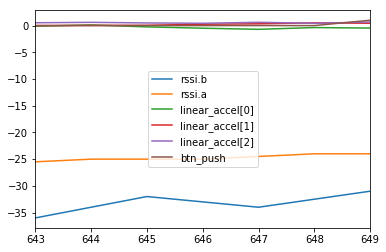

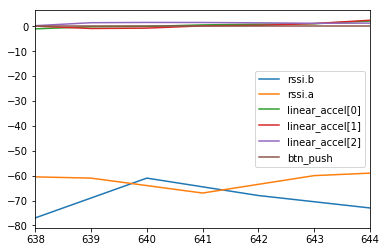

In [164]:
# load dataset
ds_nml = dataset('data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅')
ds_out = dataset('data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出')

# set column
column = ['rssi.b','rssi.a',['linear_accel[0]','linear_accel[1]','linear_accel[2]'],'btn_push']

# get around button pushed time
dfl_nml = ds_nml.get_data(before=6, after=0, column=list_flatten(column))
dfl_out = ds_out.get_data(before=6, after=0, column=list_flatten(column))
mean_std = get_mean_std(dfl_nml, column)
dfl_nml[0].plot()
dfl_out[0].plot()
print(mean_std[0])
print(mean_std[1])
dfl_nml_n = normalize(dfl_nml, mean_std)
dfl_out_n = normalize(dfl_out, mean_std)
dfl_nml_n[0].plot()
dfl_out_n[0].plot()
dfl_nml_n[0]

,rssi.b,rssi.a,linear_accel[0],linear_accel[1],linear_accel[2],btn_push
643,-1.709715,-1.385870,1.173609,-1.300502,-0.066918,-0.377964
644,-0.482227,-0.503953,2.513529,-1.142321,0.397424,-0.377964
645,0.745260,-0.503953,0.458778,-1.014416,-0.256304,-0.377964
646,0.131517,-0.503953,-0.951527,0.127091,-0.599934,-0.377964
647,-0.482227,0.377964,-2.137491,0.581627,0.426221,-0.377964
648,0.438389,1.259882,-0.262498,1.548125,-0.631272,-0.377964
649,1.359004,1.259882,-0.794400,1.200396,0.730784,2.267787


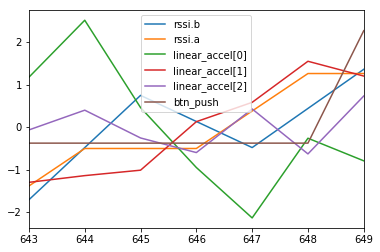

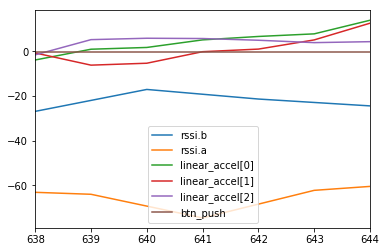

In [223]:
########################## k-NN 
from sklearn.neighbors import NearestNeighbors
#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X = normal
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
nbrs.fit(X)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=3, p=2, radius=1.0)

In [224]:
distances, indices = nbrs.kneighbors(X)
print(distances)
print(indices)

[[ 0.          0.96900979  1.18613318]
 [ 0.          0.47547992  0.56683676]
 [ 0.          0.95248595  0.97963222]
 [ 0.          0.70762178  0.87519611]
 [ 0.          0.62291934  0.73165756]
 [ 0.          0.62291934  0.96900979]
 [ 0.          0.99479435  1.00146631]
 [ 0.          0.56683676  0.6744973 ]
 [ 0.          0.7166177   0.80090115]
 [ 0.          0.47547992  0.6744973 ]]
[[0 5 4]
 [1 9 7]
 [2 9 8]
 [3 7 1]
 [4 5 1]
 [5 4 0]
 [6 5 4]
 [7 1 9]
 [8 7 1]
 [9 1 7]]
